In [27]:
#   SIR model
from matplotlib import colors
from matplotlib import gridspec
import numpy as np
import seaborn as sns
from operator import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import random
import pandas as pd

In [28]:
def change_num_prob(old_num,prob,new_num):
    if random.random() < prob:
        return new_num
    else:
        return old_num

In [29]:
# Define colors for the SIR states
threshold_tau = 8
generation_time = 200

cmap = colors.ListedColormap(['white', 'black', 'red'])
bounds = [-0.5, 0.9, threshold_tau, threshold_tau+1] # white -- susceptible, black -- infected, red -- recovered
norm = colors.BoundaryNorm(bounds, cmap.N)

# # Function to count susceptible, infected, and recovered individuals
def count_sir_states(grid):
    S = np.sum(grid == 0)  # Susceptible: tau = 0
    I = np.sum((grid >= 1) & (grid < threshold_tau))  # Infected: 1 <= tau < threshold_tau
    R = np.sum(grid == threshold_tau)  # Recovered: tau = threshold_tau
    return S, I, R

In [30]:
# SIRS model function
def sir_model(tau):
    grid_size = tau.shape[0]
    new_grid = np.copy(tau)

    for i in range(grid_size):
        for j in range(grid_size):
            tau_val = tau[i,j]

            # Periodic boundary conditions
            if i>0 and j>0 and i<grid_size-1 and j<grid_size-1:
                neighbours = [tau[i][j+1], tau[i][j-1],
                              tau[i+1][j], tau[i-1][j],
                              tau[i-1][j-1], tau[i+1][j+1],
                              tau[i+1][j-1], tau[i-1][j+1]]

            elif i==0 and j==0:
               neighbours = [tau[i][j+1], tau[i+1][j],
                             tau[i][grid_size-1], tau[grid_size-1][grid_size-1],
                             tau[grid_size-1][j], tau[grid_size-1][j+1],
                             tau[i+1][grid_size-1], tau[i+1][j+1]]

            elif i==0 and j<grid_size-1:
               neighbours = [tau[grid_size-1][j-1], tau[grid_size-1][j],
                             tau[grid_size-1][j+1], tau[i][j-1],
                             tau[i][j+1], tau[i+1][j-1],
                             tau[i+1][j], tau[i+1][j+1]]

            elif j==0 and i<grid_size-1:
               neighbours = [tau[i+1][grid_size-1], tau[i][grid_size-1],
                             tau[i+1][grid_size-1], tau[i+1][j+1],
                             tau[i][j+1], tau[i-1][j+1],
                             tau[i+1][j], tau[i-1][j]]

            elif i==grid_size-1 and j==grid_size-1:
               neighbours = [tau[grid_size-1][j-1], tau[i-1][grid_size-1],
                             tau[0][grid_size-1], tau[grid_size-1][0],
                             tau[i-1][j-1], tau[i-1][0],
                             tau[0][j-1], tau[0][0]]

            elif i==grid_size-1 and j<grid_size-1:
                 neighbours = [tau[0][j-1], tau[0][j],
                               tau[0][j+1], tau[i][j-1],
                               tau[i][j+1], tau[i-1][j-1],
                               tau[i-1][j], tau[i-1][j+1]]

            elif j==grid_size-1 and i<grid_size-1:
                 neighbours = [tau[i+1][0], tau[i][0],
                               tau[i+1][0], tau[i+1][0],
                               tau[i][0], tau[i-1][0],
                               tau[i+1][j], tau[i-1][j]]

            # Fraction of infected in neighbourhodd
            count_infected = 0
            for k in range(1,threshold_tau):
                count_infected+=countOf(neighbours,k)

            prob_infected = count_infected / 8

            # Model rules
            if tau_val == 0: 
               new_grid[i][j] = change_num_prob(0,prob_infected,1) # Susceptible

            if 1 <= tau_val < threshold_tau:  # Infected
                new_grid[i][j] = tau_val + 1

            if tau_val == threshold_tau:  # Recovered
                new_grid[i][j] = 0  # Became susceptible again  

    return new_grid

In [31]:
# Initialization of the grid
# The beginning
def initialize_grid(grid_size, threshold_tau, pattern="random"):
    grid = np.zeros((grid_size, grid_size), dtype=int)
    
    if pattern == "random":
        # Randomly assign states (0: Susceptible, 1: Infected)
        grid = np.random.choice([0,1], size=(grid_size, grid_size), p=[0.6, 0.4])
    
    elif pattern == "center_infection":
        # Create a susceptible grid with infection starting at the center
        grid.fill(0)  # Susceptible everywhere
        center = grid_size // 2
        grid[center-1:center+1, center-1:center+1] = 1  # Infected at center
    
    elif pattern == "wave":
        # Create a wave pattern of infection
        for i in range(grid_size):
            grid[i, :] = (i % 3) + 1  # Alternating between Susceptible and Infected
    
    elif pattern == "clusters":
        # Create clusters of infection
        grid.fill(0)  # Susceptible everywhere
        for _ in range(10):  # Add 10 clusters of infection
            i, j = np.random.randint(0, grid_size, size=2)
            grid[max(0, i-2):min(grid_size, i+2), max(0, j-2):min(grid_size, j+2)] = 1
    
    return grid

# Example usage:
grid_size = 50
grid = initialize_grid(grid_size, threshold_tau, pattern="random")

In [32]:
# Grid for visualization
# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(grid, cmap=cmap, norm=norm, interpolation='nearest')
ax.set_title("SIR Model Simulation")

# Add the SIR text to display percentages
generation_text = fig.text(0.015, 1.035, '', transform=ax.transAxes, color='black', fontsize=11, ha='left', va='top')
text_sir = fig.text(0.99, 1.035, '', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', alpha=0.8), ha='right', va='top')


# Initialization function for FuncAnimation
def init():
    img.set_data(grid)
    text_sir.set_text('')
    return [img, text_sir]

# Arrays for storing the data
num_infected=[]
num_susceptible=[]
num_recovered=[]

# Update function for the animation
def update(frame, img, grid, text_sir):
    new_grid = sir_model(grid)

    # Count susceptible, infected, and recovered
    S, I, R = count_sir_states(new_grid)

    # Update the image and SIR text
    img.set_data(new_grid)
    text_sir.set_text(f'S: {S/grid.shape[0]**2:.2f} I: {I/grid.shape[0]**2:.2f} R: {R/grid.shape[0]**2:.2f}')
    
    generation_text.set_text(f"Generation: {frame}")

    # Update the grid for the next frame
    grid[:] = new_grid
    num_infected.append(I)
    num_susceptible.append(S)
    num_recovered.append(R)
    return [img, text_sir]


# Create the animation
ani = animation.FuncAnimation(fig, update, fargs=(img, grid, text_sir),
                              frames=generation_time, init_func=init,
                              interval = 150, repeat = True)

plt.tight_layout()
plt.close(fig)
# Generating gif of the simulation
ani.save(f"SIRS_simulation.gif", writer="Pillow")  


MovieWriter Pillow unavailable; using Pillow instead.


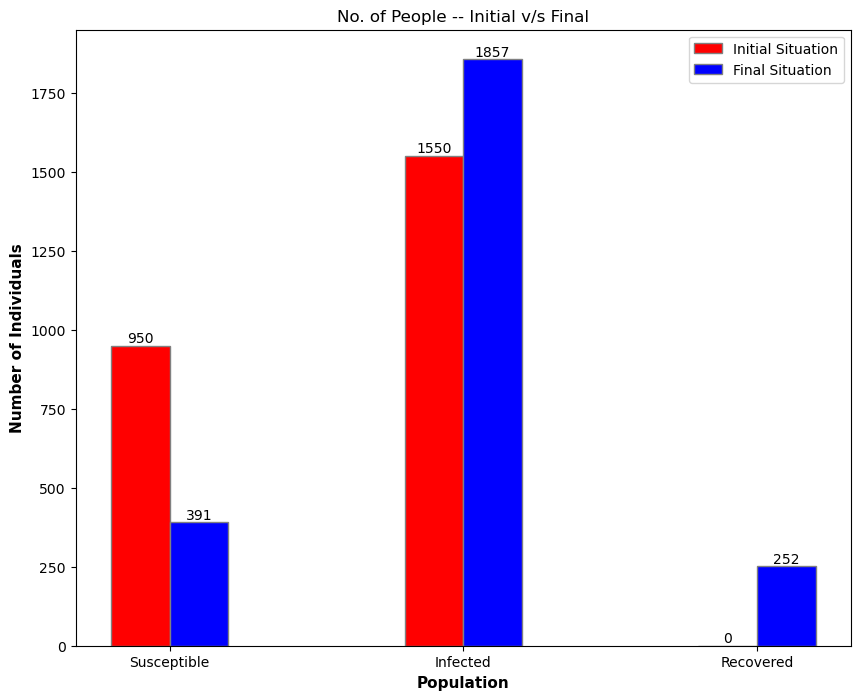

In [33]:
categories = ['Susceptible', 'Infected', 'Recovered']
production_run_time = [num_susceptible[0], num_infected[0], num_recovered[0]]
products_produced = [num_susceptible[generation_time-1], num_infected[generation_time-1], num_recovered[generation_time-1]]

# Number of bars per group
n_categories = len(categories)

# Selecting bar width
bar_width = 0.2

# Set position of bars on x-axis
r1 = np.arange(n_categories)  # positions for the first set of bars (production_run_time)
r2 = [x + bar_width for x in r1]  # positions for the second set of bars (products_produced)

# Create the plot
plt.figure(figsize=(10, 8))
plt.bar(r1, production_run_time, color='red', width=bar_width, edgecolor='grey', label='Initial Situation')
plt.bar(r2, products_produced, color='blue', width=bar_width, edgecolor='grey', label='Final Situation')

# Add labels and title
plt.xlabel('Population', fontweight='bold', fontsize=11)
plt.ylabel('Number of Individuals', fontweight='bold',fontsize=11)
plt.title('No. of People -- Initial v/s Final')

# Add xticks on the middle of the group bars
plt.xticks(r1+(bar_width/2),categories)

# Create legend
plt.legend()

for index,data in enumerate(production_run_time):
    plt.text(x=r1[index], y=data+10, s=f'{data}', ha='center') # specifying the x and y coordinate of the text

for index,data in enumerate(products_produced):
    plt.text(x=r2[index], y=data+10, s=f'{data}', ha='center')
# Show the plot
plt.show()


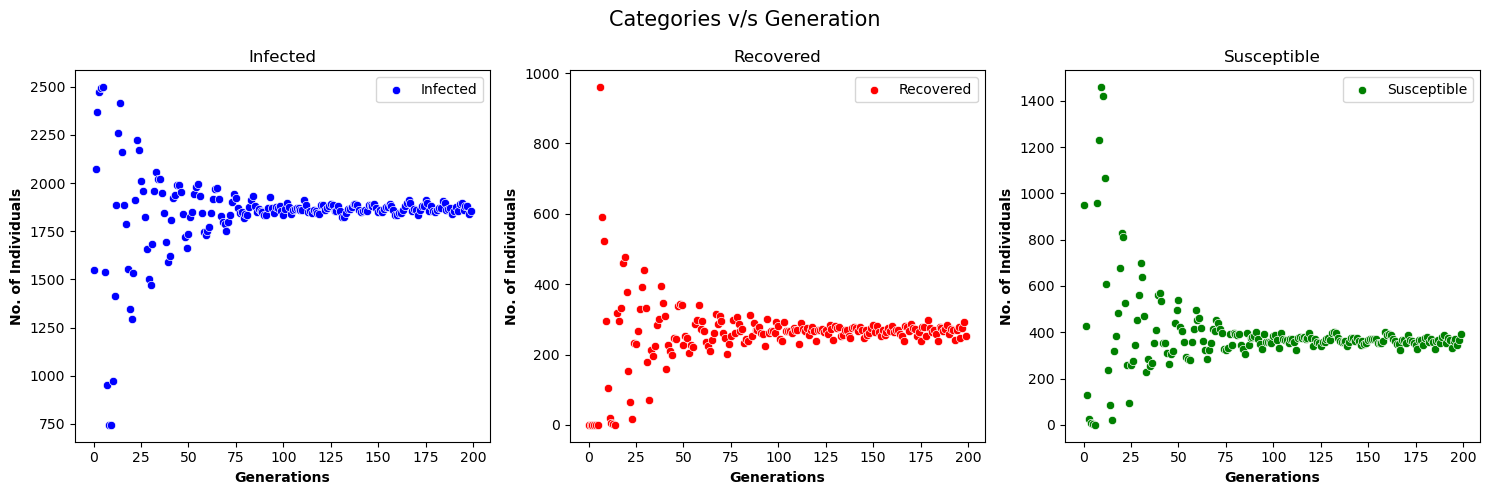

In [34]:
# Plotting the data
fig,ax = plt.subplots(1,3,figsize=(15,5))
time=np.arange(0,generation_time)

sns.scatterplot(x=time, y=num_infected, color='blue', label='Infected', ax=ax[0])
sns.scatterplot(x=time, y=num_recovered, color='red', label='Recovered', ax=ax[1])
sns.scatterplot(x=time, y=num_susceptible, color='green', label='Susceptible', ax=ax[2])

# Adding titles to each subplot for clarity
ax[0].set_title('Infected')
ax[1].set_title('Recovered')
ax[2].set_title('Susceptible')

for ax in ax.flat:
    ax.set_xlabel('Generations', fontweight='bold')
    ax.set_ylabel('No. of Individuals', fontweight='bold')

fig.suptitle('Categories v/s Generation', fontsize=15)
plt.legend()
plt.tight_layout()  # Adjusts subplot parameters for a nicer layout
plt.show()

In [35]:
number_infected = np.array(num_infected)/2500
number_susceptible = np.array(num_susceptible)/2500
number_recovered = np.array(num_recovered)/2500

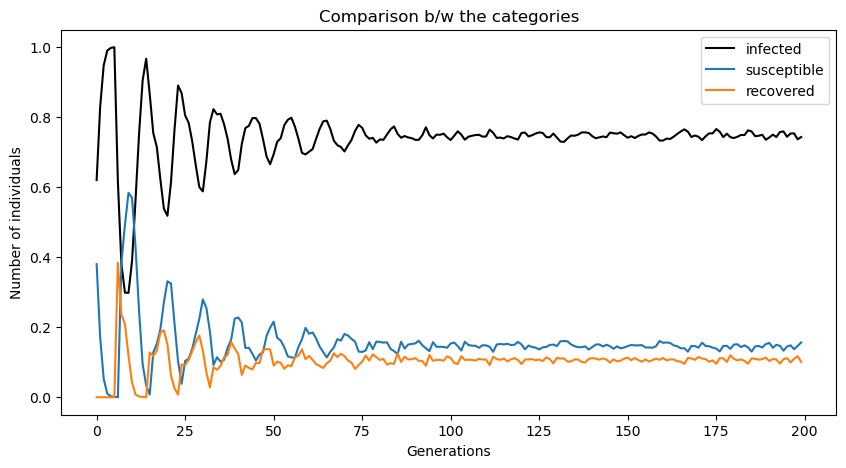

In [36]:
plt.figure(figsize=(10,5))
plt.plot(time,number_infected, color='black',label='infected')
plt.plot(time,number_susceptible,label='susceptible')
plt.plot(time,number_recovered,label='recovered')
plt.xlabel('Generations')
plt.ylabel('Number of individuals')
plt.title('Comparison b/w the categories')
plt.legend()
plt.show()